In [1]:
#######    
### This function prints off the most likely predicted 
### channels for each of the cells in our dataset
#######

#######    
### Load the Model Parts
#######

import argparse
import SimpleLogger as SimpleLogger

import importlib
import numpy as np

import os
import pickle

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils

#have to do this import to be able to use pyplot in the docker image
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from IPython import display
import time
from model_utils import set_gpu_recursive, load_model, save_state, save_progress, get_latent_embeddings, maybe_save

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import pdb

parent_dir = './test_aaegan/aaegan3Dv5_128D'

model_dir = parent_dir + os.sep + 'struct_model' 

# logger_file = '{0}/logger_tmp.pkl'.format(model_dir)
opt = pickle.load( open( '{0}/opt.pkl'.format(model_dir), "rb" ) )

print(opt)

DP = importlib.import_module("data_providers." + opt.dataProvider)
model_provider = importlib.import_module("models." + opt.model_name)
train_module = importlib.import_module("train_modules." + opt.train_module)

torch.manual_seed(opt.myseed)
torch.cuda.manual_seed(opt.myseed)
np.random.seed(opt.myseed)

if not os.path.exists(opt.save_dir):
    os.makedirs(opt.save_dir)
    
if opt.nepochs_pt2 == -1:
    opt.nepochs_pt2 = opt.nepochs

opts = {}
opts['verbose'] = True
opts['pattern'] = '*.tif_flat.png'
opts['out_size'] = [opt.imsize, opt.imsize]

data_path = './data_{0}x{1}.pyt'.format(str(opts['out_size'][0]), str(opts['out_size'][1]))
if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(opt.imdir, opts)
    torch.save(dp, data_path)
    
dp.opts['dtype'] = 'float'
    
if opt.ndat == -1:
    opt.ndat = dp.get_n_dat('train')    

iters_per_epoch = np.ceil(opt.ndat/opt.batch_size)    
            
#######    
### Load REFERENCE MODEL
#######

embeddings_path = opt.save_parent + os.sep + 'ref_model' + os.sep + 'embeddings.pkl'
if os.path.exists(embeddings_path):
    embeddings = torch.load(embeddings_path)
else:
    embeddings = get_latent_embeddings(models['enc'], dp, opt)
    torch.save(embeddings, embeddings_path)

models = None
optimizers = None
    
def get_ref(self, inds, train_or_test='train'):
    inds = torch.LongTensor(inds)
    return self.embeddings[train_or_test][inds]

dp.embeddings = embeddings

# do this thing to bind the get_ref method to the dataprovider object
import types  
dp.get_ref = types.MethodType(get_ref, dp)
            

opt.channelInds = [0, 1, 2]
dp.opts['channelInds'] = opt.channelInds
opt.nch = len(opt.channelInds)
        
opt.nClasses = dp.get_n_classes()
opt.nRef = opt.nlatentdim

try:
    train_module = None
    train_module = importlib.import_module("train_modules." + opt.train_module)
    train_module = train_module.trainer(dp, opt)
except:
    pass    

if not hasattr(opt, 'critRecon'):
    opt.critRecon = 'BCELoss'
    
if not hasattr(opt, 'dtype'):
    opt.dtype = 'float'

# pdb.set_trace()
opt.gpu_ids = [0, 1]
models, optimizers, criterions, logger, opt = load_model(model_provider, opt)

enc = models['enc']
dec = models['dec']
enc.train(False)
dec.train(False)

models = None
optimizers = None


print('Done loading model.')

# Get the embeddings for the structure localization

opt.batch_size = 100
# opt.gpu_ids = [0,1,3]
enc.gpu_ids = opt.gpu_ids
dec.gpu_ids = opt.gpu_ids

embeddings_path = opt.save_dir + os.sep + 'embeddings_struct.pkl'
if os.path.exists(embeddings_path):
    embeddings = torch.load(embeddings_path)
else:
    embeddings = get_latent_embeddings(enc, dp, opt)
    torch.save(embeddings, embeddings_path)

enc = None    
    
print('Done loading embeddings.')

Namespace(Diters=5, DitersAlt=100, batch_size=32, channelInds=[0, 1, 2], channels_pt1=[0, 2], channels_pt2=[0, 1, 2], critRecon='BCELoss', dataProvider='DataProvider3Dh5', decDRatio=0.0001, dtype='float', encDRatio=0.0001, gpu_ids=[0, 1], imdir='/root/results/ipp_dataset_cellnuc_seg_curated_7_24_17', imsize=8, latentDistribution='gaussian', latentSample=<function sampleGaussian at 0x7f2e5a8df598>, lrDec=0.0002, lrDecD=0.0002, lrEnc=0.0002, lrEncD=0.01, model_name='aaegan3Dv5', myseed=0, nClasses=10, nRef=128, nch=3, nclasses=1, ndat=14235, nepochs=200, nepochs_pt2=250, nlatentdim=128, noise=0.01, noise_std=0, optimizer='adam', saveProgressIter=1, saveStateIter=1, save_dir='./test_aaegan/aaegan3Dv5_128D//struct_model', save_parent='./test_aaegan/aaegan3Dv5_128D/', train_module='aaegan_trainv2')
Loading from ./test_aaegan/aaegan3Dv5_128D//struct_model
Done loading model.
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
0/143
1/143
2/143
3/143
4/143
5/

In [2]:
#######    
### Main Loop
#######

import pdb
from aicsimage.io import omeTifWriter
from imgToProjection import imgtoprojection
from IPython.core.display import display
import PIL.Image
import matplotlib.pyplot as plt
import scipy.misc

import pandas as pd



opt.batch_size = 400
gpu_id = opt.gpu_ids[0]

loss = nn.MSELoss()
embeddings_all = torch.cat([embeddings['train'], embeddings['test']], 0);

dat_train_test = ['train'] * len(embeddings['train']) + ['test'] * len(embeddings['test'])
dat_dp_inds = np.concatenate([np.arange(0, len(embeddings['train'])), np.arange(0, len(embeddings['test']))], axis=0).astype('int')
dat_inds = np.concatenate([dp.data['train']['inds'], dp.data['test']['inds']])

err_cols = ['err_' + train_or_test + '_' + str(i) + '_' + str(img_index) for train_or_test, i, img_index in zip(dat_train_test, dat_dp_inds, dat_inds)]

colormap = 'hsv'
colors = plt.get_cmap(colormap)(np.linspace(0, 1, 4))

px_size = [0.3873, 0.3873, 0.3873]

train_or_test_split = ['test', 'train']

img_paths_all = list()

save_parent = opt.save_dir + os.sep + 'var_test' + os.sep
if not os.path.exists(save_parent):
    os.makedirs(save_parent)

def convert_image(img):
    img = img.data[0].cpu().numpy()
    img = np.transpose(img, (3, 0, 1, 2))
    
    return img

# For train or test
# pdb.set_trace()

for train_or_test, i, img_index, c in zip(dat_train_test, dat_dp_inds, dat_inds, range(0, len(dat_dp_inds))):
    
    
    img_class = dp.image_classes[img_index]    
    img_class_onehot = dp.get_classes([i], train_or_test, 'onehot')
    
    img_name = dp.get_image_paths([i], train_or_test)[0]    
    img_name = os.path.basename(img_name)
    img_name = img_name[0:img_name.rfind('.')]
    
    save_dir = save_parent + os.sep + train_or_test + os.sep + img_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    err_save_path = save_dir + os.sep + img_name + '.csv'
    if os.path.exists(err_save_path):
        continue

    print(str(c) + os.sep + str(len(dat_dp_inds)))
    #Load the image
    img_in = dp.get_images([i], train_or_test)
    img_in = Variable(img_in.cuda(gpu_id), volatile=True)

    img_in_struct = torch.index_select(img_in, 1, torch.LongTensor([1]).cuda(gpu_id))

    
    
    #pass forward through the model
#     enc.gpu_ids = [gpu_id]
#     z = enc(img_in)

    shape_embedding = embeddings[train_or_test][i]
    
    #set the class label so it is correct
    img_class_onehot_log = (img_class_onehot - 1) * 25

    #go through embeddings
    nembeddings = embeddings_all.size()[0]
    inds = list(range(0,nembeddings))
    data_iter = [inds[j:j+opt.batch_size] for j in range(0, len(inds), opt.batch_size)]        

    errors = list()
    z = [None] * 3

    for j in range(0, len(data_iter)):
#         print('cell: ' + str(i) + ', ' + str(j) + '/' + str(len(data_iter)))

        batch_inds = data_iter[j]
        batch_size = len(data_iter[j])

        z[0] = Variable(img_class_onehot_log.repeat(batch_size, 1).float(), volatile=True).cuda(gpu_id)
        z[1] = Variable(shape_embedding.repeat(batch_size,1), volatile=True).cuda(gpu_id)

        struct_embeddings = embeddings_all.index(torch.Tensor(batch_inds).long())
        z[2] = Variable(struct_embeddings, volatile=True).cuda(gpu_id)

#             try:
        imgs_out = dec(z)
#             except:
#                 pdb.set_trace()

        imgs_out = torch.index_select(imgs_out, 1, torch.LongTensor([1]).cuda(gpu_id))

        for img in imgs_out:
            errors.append(loss(img, img_in_struct).data[0])

    tot_inten = torch.sum(img_in_struct).data[0]

    df = pd.DataFrame([[img_index, i, img_class, img_name, tot_inten, train_or_test] + errors], columns=['img_index', 'data_provider_index', 'label', 'path', 'tot_inten', 'train_or_test'] + err_cols)
    df.to_csv(err_save_path)
        
print('Done computing errors.')

0/15827
1/15827
2/15827
3/15827
4/15827
5/15827
6/15827
7/15827
8/15827
9/15827
10/15827
11/15827
12/15827
13/15827
14/15827
15/15827
16/15827
17/15827
18/15827
19/15827
20/15827
21/15827
22/15827
23/15827
24/15827
25/15827
26/15827
27/15827
28/15827
29/15827
30/15827
31/15827
32/15827
33/15827
34/15827
35/15827
36/15827
37/15827
38/15827
39/15827
40/15827
41/15827
42/15827
43/15827
44/15827
45/15827
46/15827
47/15827
48/15827
49/15827
50/15827
51/15827
52/15827
53/15827
54/15827
55/15827
56/15827
57/15827
58/15827
59/15827
60/15827
61/15827
62/15827
63/15827
64/15827
65/15827
66/15827
67/15827
68/15827
69/15827
70/15827
71/15827
72/15827
73/15827
74/15827
75/15827
76/15827
77/15827
78/15827
79/15827
80/15827
81/15827
82/15827
83/15827
84/15827
85/15827
86/15827
87/15827
88/15827
89/15827
90/15827


KeyboardInterrupt: 

In [ ]:
type(dat_dp_inds[0])


In [ ]:
save_all_path = save_parent + os.sep + 'all_dat.csv'

if not os.path.exists(save_all_path):
    csv_list = list()

    # For train or test
    for train_or_test in train_or_test_split:
        ndat = dp.get_n_dat(train_or_test)
        # For each cell in the data split
        for i in range(0, ndat):
            print(str(i) + os.sep + str(ndat))

            img_index = dp.data[train_or_test]['inds'][i]
            img_class = dp.image_classes[img_index]

            img_class_onehot = dp.get_classes([i], train_or_test, 'onehot')
            img_name = os.path.basename(dp.image_paths[img_index])[0:-3]

            save_dir = save_parent + os.sep + train_or_test + os.sep + img_name
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            err_save_path = save_dir + os.sep + img_name + '.csv'
            if os.path.exists(err_save_path):
                csv_errors = pd.read_csv(err_save_path)
#                 csv_errors['train_or_test'] = train_or_test
                csv_list.append(csv_errors)
            else:
                print('Missing ' +  err_save_path)

    errors_all = pd.DataFrame(csv_list)

    errors_all.to_csv(save_all_path)
else:
    errors_all = pd.read_csv(save_all_path)

    
ulabels = np.unique(errors_all['label'])

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

errors = errors_all.filter(regex='recon_err')
errors_mean = errors.median(axis=1)

errors_mean[np.isnan(errors_mean)] = math.huge

errors_mean = np.divide(errors_mean, errors_all['tot_inten'])

min_bin = np.prctile(errors_mean, 2)
max_bin = np.prctile(errors_mean, 98)

bins = np.linspace(min_bin, max_bin, 250)

c = 0

for train_or_test in train_or_test_split:
    c+=1
    plt.subplot(len(train_or_test_split), 1, c)
    
    train_inds = errors_all['train_or_test'] == train_or_test
    
    for label in ulabels:
        label_inds = errors_all['label'] == label
        
        inds = np.logical_and(train_inds, label_inds)
        
        legend_key = label
        plt.hist(errors_mean[inds], bins, alpha=0.5, label=legend_key, normed=True)
        
    
plt.legend(loc='upper right')
plt.show()

In [ ]:
from data_providers.DataProvider3D import load_h5 
from model_utils import tensor2img
from IPython.core.display import display
import PIL.Image

def get_images(dp, paths):
    dims = list(dp.imsize)
    dims[0] = len(dp.opts['channelInds'])

    dims.insert(0, len(paths))

    images = torch.zeros(tuple(dims))

    if dp.opts['dtype'] == 'half':
        images = images.type(torch.HalfTensor)

    c = 0
    for h5_path in paths:
        image = load_h5(h5_path)
        image = torch.from_numpy(image)
        images[c] = image.index_select(0, torch.LongTensor(dp.opts['channelInds'])).clone()
        c += 1

    # images *= 2
    # images -= 1
    return images



for label in ulabels:
    print(label)
    label_inds = errors_all['label'] == label

    imgs_flat = list()
#         label_inds = errors_all['label'] == 'Alpha tubulin'
    for train_or_test in train_or_test_split:
#         print(train_or_test)
        train_inds = errors_all['train_or_test'] == train_or_test
        inds = np.where(np.logical_and(train_inds, label_inds))

        inds_sorted = np.argsort(errors_mean[inds[0]])

        errors_sub = errors_all.loc[inds[0][inds_sorted]]

        im_paths = [dp.image_paths[i] for i in errors_sub.iloc[0:10]['img_index']]
        img_out = get_images(dp, im_paths)
        img_flat_low_err = tensor2img(img_out)
        
        im_paths = [dp.image_paths[i] for i in errors_sub.iloc[-10:]['img_index']]
        img_out = get_images(dp, im_paths)
        img_flat_hi_err = tensor2img(img_out)
    
        imsize = img_flat_low_err.shape
        border = np.ones([imsize[0], 10, 3])
    
        img_flat = np.concatenate([img_flat_low_err, border, img_flat_hi_err], axis=1)
        imgs_flat.append(img_flat)
    
    display(PIL.Image.fromarray(np.uint8(np.concatenate(imgs_flat)*255)))


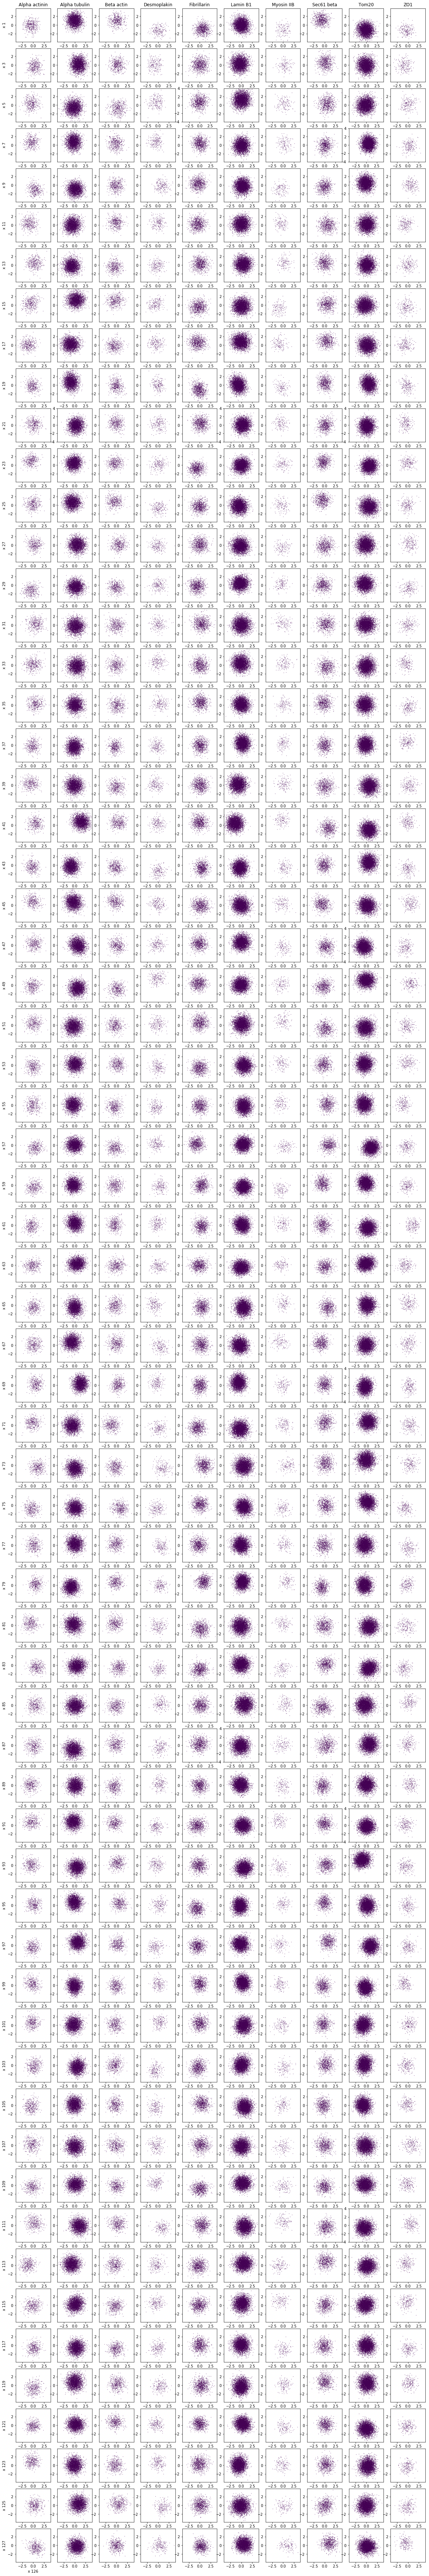

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

classes = dp.get_classes(np.arange(0, dp.get_n_dat('train')), 'train').numpy()
embeddings_tmp = embeddings['train'].numpy()

uclasses = np.unique(classes)

ndims = embeddings['train'].shape[1]
nrows = ndims/2


plt.figure(figsize=(20, 2*nrows))

counter = 1
           
for dim in np.arange(0, ndims, 2):

    for uclass in uclasses:

        
        class_inds = classes == uclass;


        plt.subplot(nrows, len(uclasses), counter)
        plt.scatter(embeddings_tmp[class_inds,dim], embeddings_tmp[class_inds,dim+1], c=classes[class_inds], s=0.1)
        plt.axis('equal')
        plt.axis([-4, 4, -4, 4])
        
        
        if uclass == 0:
            plt.xlabel('x ' + str(dim))
            plt.ylabel('x ' + str(dim+1))

        if dim == 0: plt.title(dp.label_names[uclass])

        counter += 1

plt.savefig('{0}/latent_space.png'.format(model_dir), bbox_inches='tight')

In [6]:
uclasses

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])